# Modelo MLP para Previsão de Preços de Criptomoedas

## Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, Normalizer, FunctionTransformer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax, AdamW, Lion, RMSprop
import joblib

## PASSO 1: Carregar e Preparar os Dados

**Objetivo:** Ler o arquivo CSV e garantir que ele esteja em ordem.

In [ ]:
# Carrega os dados do arquivo CSV
df = pd.read_csv(r"C:\Users\david\Desktop\trading-algoritmico\data\fechamentos\SOLUSDT_5m_data.csv")

# Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)

# Remove colunas com nomes "Unnamed".
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Dados carregados: {df.shape[0]} registros.")
print(df.head())

Dados carregados: 17520 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 16:00:00  25.69  25.77  25.21  25.51  414795.24
1 2023-07-20 17:00:00  25.52  25.67  25.40  25.57  150201.53
2 2023-07-20 18:00:00  25.58  25.58  25.25  25.40  193565.98
3 2023-07-20 19:00:00  25.40  25.52  25.27  25.39  141808.90
4 2023-07-20 20:00:00  25.40  25.40  25.03  25.23  238536.03


## PASSO 2: Preparar os Dados para o Modelo

**Objetivo:** Transformar os dados brutos em um formato que a rede neural entenda (features e target).

In [ ]:
# --- Calculo dos Indicadores ---
# Calcula as variações percentuais de 'close' e 'volume'
df['close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

# Converte close_pct e volume_pct para logaritmo
df['close_pct'] = np.log(1 + df['close_pct'])
df['volume_pct'] = np.log(1 + df['volume_pct'])

# Calcula a média móvel simples de 10 e 30 períodos para 'close'
df['sma_10'] = df['close'].rolling(window=10).mean()
df['sma_30'] = df['close'].rolling(window=30).mean()

# Calcula o Índice de Força Relativa (RSI) de 14 períodos
def rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0).rolling(window=period).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=period).mean()
    # Adiciona um pequeno epsilon para evitar divisão por zero
    rs = gain / (loss + 1e-10)
    return 100 - (100 / (1 + rs))
df['rsi_7'] = rsi(df['close'], period=7)
df['rsi_14'] = rsi(df['close'], period=14)
df['rsi_21'] = rsi(df['close'], period=21)

# Calcula o MACD
def macd(series, short_window=12, long_window=26, signal_window=9):
    exp1 = series.ewm(span=short_window, adjust=False).mean()
    exp2 = series.ewm(span=long_window, adjust=False).mean()
    macd_line = exp1 - exp2
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line
df['macd'], df['macd_signal'] = macd(df['close'])

# Calcula o Bollinger Bands
def bollinger_bands(series, window=20, num_std_dev=2):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std_dev)
    lower_band = rolling_mean - (rolling_std * num_std_dev)
    return upper_band, lower_band
df['bb_upper'], df['bb_lower'] = bollinger_bands(df['close'])

# Diferença entre o preço de fechamento e as bandas de Bollinger
df['bb_lower_diff'] = df['close'] - df['bb_lower']
df['bb_upper_diff'] = df['bb_upper'] - df['close']

# Calcula o Average True Range (ATR)
def atr(df, window=14):
    high_low = df['high'] - df['low']
    high_prev_close = abs(df['high'] - df['close'].shift())
    low_prev_close = abs(df['low'] - df['close'].shift())
    tr = pd.DataFrame({'hl': high_low, 'hpc': high_prev_close, 'lpc': low_prev_close}).max(axis=1)
    atr_val = tr.rolling(window=window).mean()
    return atr_val
df['atr_14'] = atr(df, window=14) # Adicionando ATR de 14 períodos

# Calcula o Stochastic Oscillator (%K e %D)
def stochastic_oscillator(df, k_window=14, d_window=3):
    lowest_low = df['low'].rolling(window=k_window).min()
    highest_high = df['high'].rolling(window=k_window).max()
    k_percent = ((df['close'] - lowest_low) / (highest_high - lowest_low)) * 100
    d_percent = k_percent.rolling(window=d_window).mean()
    return k_percent, d_percent
df['so_k'] = stochastic_oscillator(df)[0] # %K do Stochastic
df['so_d'] = stochastic_oscillator(df)[1] # %D (média de %K) do Stochastic

# Calcula o Williams %R
def williams_percent_r(df, window=14):
    lowest_low = df['low'].rolling(window=window).min()
    highest_high = df['high'].rolling(window=window).max()
    wpr = ((highest_high - df['close']) / (highest_high - lowest_low)) * -100
    return wpr
df['wpr_14'] = williams_percent_r(df, window=14) # Williams %R de 14 períodos

# Calcula o On-Balance Volume (OBV)
def on_balance_volume(df):
    obv = pd.Series(0, index=df.index)
    for i in range(1, len(df)):
        if df['close'].iloc[i] > df['close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] + df['volume'].iloc[i]
        elif df['close'].iloc[i] < df['close'].iloc[i-1]:
            obv.iloc[i] = obv.iloc[i-1] - df['volume'].iloc[i]
        else:
            obv.iloc[i] = obv.iloc[i-1]
    return obv
df['obv'] = on_balance_volume(df)

# Calcula o desvio padrão de 10, 20 e 40 períodos
df['std_10'] = df['close'].rolling(window=10).std()
df['std_20'] = df['close'].rolling(window=20).std()
df['std_40'] = df['close'].rolling(window=40).std()

# Calcula a média móvel exponencial de 10 e 30 períodos
df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()

# Calcula indicadores lagging
df['lag_close_pct_1'] = df['close_pct'].shift(1)  # Preço de fechamento do período anterior
df['lag_close_pct_2'] = df['close_pct'].shift(2)  # Preço de fechamento de dois períodos atrás

df['lag_rsi_7_1'] = df['rsi_7'].shift(1)  # RSI do período anterior
df['lag_rsi_7_2'] = df['rsi_7'].shift(2)  # RSI de dois períodos atrás

df['lag_rsi_14_1'] = df['rsi_14'].shift(1)  # RSI de 14 períodos do período anterior
df['lag_rsi_14_2'] = df['rsi_14'].shift(2)  # RSI de 14 períodos de dois períodos atrás

df['lag_rsi_21_1'] = df['rsi_21'].shift(1)  # RSI de 21 períodos do período anterior
df['lag_rsi_21_2'] = df['rsi_21'].shift(2)  # RSI de 21 períodos de dois períodos atrás

df['lag_macd_1'] = df['macd'].shift(1)  # MACD do período anterior
df['lag_macd_2'] = df['macd'].shift(2)  # MACD de dois períodos atrás

df['lag_macd_signal_1'] = df['macd_signal'].shift(1)  # Sinal do MACD do período anterior
df['lag_macd_signal_2'] = df['macd_signal'].shift(2)  # Sinal do MACD de dois períodos atrás

# Distância do preço atual para a média móvel (mostra se está sobrecomprado/sobrevendido)
df['price_vs_sma30'] = df['close'] - df['sma_30']

# Cruzamento de médias móveis (um forte indicador de tendência)
df['sma_10_vs_sma_30'] = df['sma_10'] - df['sma_30']

# Diferença do MACD para a sua linha de sinal
df['macd_diff'] = df['macd'] - df['macd_signal']

# Volatilidade (desvio padrão dos retornos logarítmicos)
df['volatility_10'] = df['close'].pct_change().rolling(window=10).std()
df['volatility_20'] = df['close'].pct_change().rolling(window=20).std()
df['volatility_40'] = df['close'].pct_change().rolling(window=40).std()

# Features de tempo para capturar sazonalidade
df['hour'] = df['timestamp'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/23.0) # Seno da hora
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/23.0) # Cosseno da hora
df.drop('hour', axis=1, inplace=True)

df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Feature de tendência de volume
df['volume_trend'] = df['volume'].pct_change().rolling(window=10).mean()

# Feature de tendência de preço
df['price_trend'] = df['close'].pct_change().rolling(window=10).mean()

# Apaga as linhas com valores NaN
df = df.dropna()
df = df.reset_index(drop=True)


C:\Users\david\AppData\Local\Temp\ipykernel_8576\1715715354.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '150201.53' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  obv.iloc[i] = obv.iloc[i-1] + df['volume'].iloc[i]


In [ ]:
# --- Definição das Variáveis ---
FEATURE_COLUMNS = [
    'close_pct',          # O último retorno registrado.
    'lag_close_pct_1',    # O retorno imediatamente anterior.
    'lag_close_pct_2',    # O retorno de dois períodos atrás.
    'macd_diff',          # Captura a mudança no momento (momentum).
    'atr_14',             # A melhor variável na análise de Informação Mútua.
    'volatility_10',      # Medida de volatilidade de curto prazo.
    'volatility_20',      # Medida de volatilidade de médio prazo.
    'std_10',             # Desvio padrão dos retornos, outra ótima medida.
    'bb_lower_diff',      # Distância para a Banda de Bollinger inferior.
    'bb_upper_diff',      # Distância para a Banda de Bollinger superior.
    'volume',             # Volume bruto, muito importante em ambas as análises.
    'obv',                # On-Balance Volume, forte em ambas as análises.
    'volume_trend',       # Importante para o modelo.
    'price_vs_sma30',     # Onde o preço está em relação à sua média.
    'price_trend',        # Tendência de curto prazo do preço.
]
TARGET_COLUMN = 'close'

# Quantos períodos olharemos para trás para prever o próximo
SEQUENCE_LENGTH = 36

# --- Criação das Features (X) e do Alvo (y) ---
# O alvo (y) será binário: 1 se o preço subir, 0 se não
# df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período
y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

# As features (X) serão os dados da FEATURE_COLUMNS
X_raw = df[FEATURE_COLUMNS]

num_features = len(FEATURE_COLUMNS)

print(f"Quantidade de features definidas: {num_features}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Shape dos dados brutos: {X_raw.shape}")
print(f"Valores mínimos {X_raw.min()}")
print(f"Valores máximos {X_raw.max()}")

Quantidade de features definidas: 11
Sequence length: 72
Shape dos dados brutos: (17480, 11)


In [ ]:
# --- Normalização dos Dados ---

# Pipeline de normalização: Log transformation + Tanh transformation + Vector normalization

# Função personalizada para transformação logaritma
def log_transform(X):
    """Aplica transformação logaritma aos dados"""
    return np.log(X + 1)  # Adiciona 1 para evitar log(0)

# Função personalizada para transformação Tanh
def tanh_transform(X):
    """Aplica transformação tanh aos dados para reduzir outliers"""
    return np.tanh(X)

# # Criar o pipeline de normalização
# scaler = Pipeline([
#     # ('log', FunctionTransformer(log_transform, validate=True)),
#     ('tanh', FunctionTransformer(tanh_transform, validate=True)),
#     ('normalize', Normalizer(norm='l2')),  # Normalização L2 (vetorial)
#     # ('minmax', MinMaxScaler(feature_range=(-1, 1)))
# ])

scaler = RobustScaler()

X_scaled = scaler.fit_transform(X_raw)

print(f"Dados normalizados com Tanh + Vector Normalization. Shape: {X_scaled.shape}")
print(f"Min: {X_scaled.min():.6f}, Max: {X_scaled.max():.6f}")
# print(f"Norma L2 das primeiras 5 amostras: {np.linalg.norm(X_scaled[:5], axis=1)}")

Dados normalizados com Tanh + Vector Normalization. Shape: (17480, 11)
Min: -9.686561, Max: 35.326302


In [ ]:
# --- Criação das Sequências ---
# Cria sequências de dados para o modelo
X_sequences, y_sequences = [], []

# Verificar o tamanho correto para evitar index out of bounds
max_index = min(len(X_scaled), len(y)) - SEQUENCE_LENGTH

print(f"Tamanho de X_scaled: {len(X_scaled)}")
print(f"Tamanho de y: {len(y)}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Max index para loop: {max_index}")

for i in range(max_index):
    X_sequences.append(X_scaled[i : i + SEQUENCE_LENGTH])
    y_sequences.append(y[i + SEQUENCE_LENGTH - 1]) # O alvo corresponde ao final da sequência

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")

Tamanho de X_scaled: 17480
Tamanho de y: 17480
Sequence length: 72
Max index para loop: 17408
Sequências criadas. X shape: (17408, 72, 11), y shape: (17408,)


In [232]:
# # --- Reshape do X para o MLP ---
# # O MLP espera uma entrada 2D, então precisa achatar as sequências
# num_samples = X.shape[0]
# num_features_flat = X.shape[1] * X.shape[2]
# X = X.reshape(num_samples, num_features_flat)

# print(f"Shape de X (features): {X.shape}")
# print(f"Shape de y (alvo): {y.shape}")

In [ ]:
# --- Divisão em Treino e Teste ---
# Divisão dos dados em treino e teste
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# Tentativa de balancear as classes, evitando a mesma reposta sempre
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de teste: {len(X_test)}")
print(f"Distribuição do target no treino: {np.bincount(y_train)}")
print(f"Distribuição do target no teste: {np.bincount(y_test)}")

Amostras de treino: 14507
Amostras de teste: 2901
Distribuição do target no treino: [7238 7269]
Distribuição do target no teste: [1424 1477]


## PASSO 3: Construir o Modelo (MLP)

**Objetivo:** Definir a arquitetura da nossa rede neural.

In [ ]:
model = Sequential()

# Camada de Entrada: Uso do Conv1D para capturar padrões temporais
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(SEQUENCE_LENGTH, num_features)))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

model.add(BatchNormalization())

# Camada de Pooling: Reduz a dimensionalidade e extrai características importantes
model.add(MaxPooling1D(pool_size=2))

# Achata a saída do Conv1D para ser usada nas camadas densas
model.add(Flatten())

# 1ª Camada Oculta: Primeira camada que aprende os padrões
model.add(Dense(units=64, kernel_regularizer=regularizers.l2(0.001)))

model.add(BatchNormalization())

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
# model.add(Dropout(rate=0.5))

# 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
model.add(Dense(units=32, kernel_regularizer=regularizers.l2(0.001)))

model.add(BatchNormalization())

# PReLU é uma ativação que pode aprender a inclinação
model.add(PReLU())

# Camada de Dropout: Ajuda a prevenir overfitting
# model.add(Dropout(rate=0.3))

# Camada de Saída: Gera a previsão final
model.add(Dense(units=1, activation='sigmoid'))

C:\Users\david\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# --- Compilação do Modelo ---
# O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)              │ (None, 70, 64)         │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 35, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │       286,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_14 (PReLU)              │ (None, 128)            │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 289,281 (1.10 MB)

 Trainable params: 289,281 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

## PASSO 4: Treinar o Modelo

**Objetivo:** Alimentar o modelo com os dados de treino para que ele aprenda.

In [ ]:
# Callbacks para otimizar o treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.000001)]

history = model.fit(
    X_train,
    y_train,
    epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
    batch_size=16,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
    validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
    class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
    callbacks=callbacks,  # Callbacks para otimização do treinamento
    verbose=1 # Mostra uma barra de progresso.
)

Epoch 1/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5013 - loss: 0.7188 - val_accuracy: 0.4984 - val_loss: 0.6961 - learning_rate: 1.0000e-04
Epoch 2/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5318 - loss: 0.6914 - val_accuracy: 0.4995 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 3/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5488 - loss: 0.6850 - val_accuracy: 0.4912 - val_loss: 0.6996 - learning_rate: 1.0000e-04
Epoch 4/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5631 - loss: 0.6779 - val_accuracy: 0.4916 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 5/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5881 - loss: 0.6716 - val_accuracy: 0.5140 - val_loss: 0.6996 - learning_rate: 1.0000e-04
Epoch 6/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5976 - loss: 0.6668 - val_accuracy: 0.5064 - val_loss: 0.7019 - learning_rate: 1.0000e-04
Epoch 7/200
454/454 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - acc

## PASSO 5: Avaliar o Modelo

**Objetivo:** Verificar o quão bem o modelo se saiu nos dados de teste.

In [ ]:
# Fazer previsões nos dados de teste. A saída será uma probabilidade
probabilities = model.predict(X_test)

# best_accuracy = -np.inf
# best_threshold = 0
# for threshold in np.arange(0.500, 0.515, 0.0001):
#     predictions = (probabilities > threshold).astype(int)
#     current_acc = accuracy_score(y_test, predictions)
#     if current_acc > best_accuracy:
#         best_accuracy = current_acc
#         best_threshold = threshold
#         print(f"Melhor acurácia até agora: {best_accuracy:.4f} com threshold {best_threshold:.4f}")

# Converter probabilidades em classes (0 ou 1) usando um limiar de 0.5
predictions = (probabilities > 0.5).astype(int)

# Calcular e mostrar as métricas
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['Não Sobe', 'Sobe'])

print(f"Acurácia no Teste: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(report)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Acurácia no Teste: 49.95%

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Sobe       0.49      0.51      0.50      1424
        Sobe       0.51      0.49      0.50      1477

    accuracy                           0.50      2901
   macro avg       0.50      0.50      0.50      2901
weighted avg       0.50      0.50      0.50      2901




Matriz de Confusão:


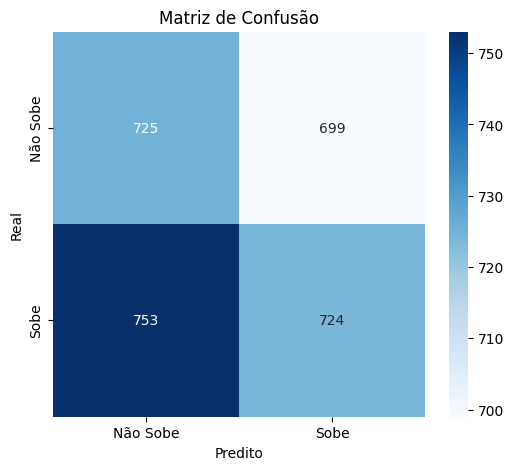

In [ ]:
print("\nMatriz de Confusão:")
# Um mapa de calor para visualizar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

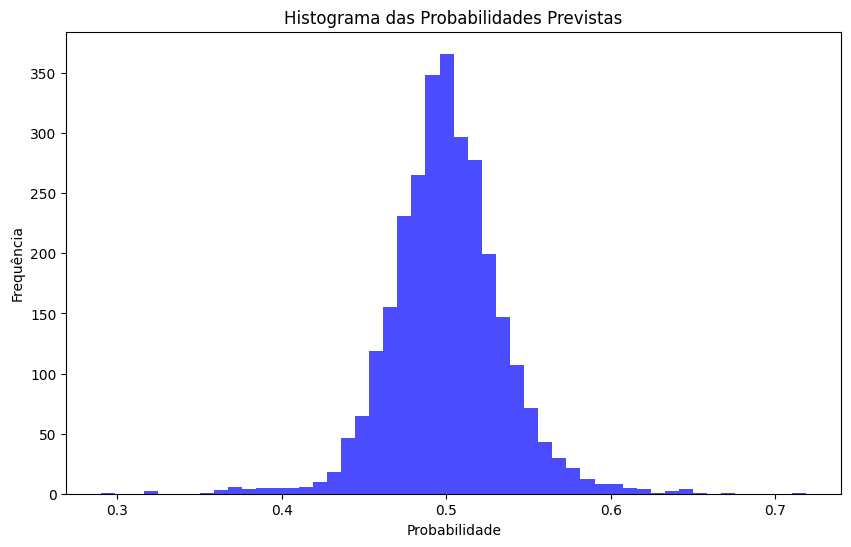

In [239]:
# Histograma das probabilidades previstas
plt.figure(figsize=(10, 6))
plt.hist(probabilities, bins=50, color='blue', alpha=0.7)
plt.title('Histograma das Probabilidades Previstas')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência')
plt.show()

## PASSO 6: Visualizar o Treinamento

**Objetivo:** Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.

In [240]:
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## PASSO 7: Salvar o Modelo

**Objetivo:** Salvar o modelo treinado e o normalizador para uso futuro.

In [ ]:
# Por enquanto não é necessário salvar o modelo
'''
MODEL_PATH = "mlp_basic_model.h5"
SCALER_PATH = "basic_scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"Normalizador salvo em: {SCALER_PATH}")
'''

'\nMODEL_PATH = "mlp_basic_model.h5"\nSCALER_PATH = "basic_scaler.pkl"\n\nmodel.save(MODEL_PATH)\njoblib.dump(scaler, SCALER_PATH)\n\nprint(f"Modelo salvo em: {MODEL_PATH}")\nprint(f"Normalizador salvo em: {SCALER_PATH}")\n'

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR (ERA POR CAUSA DO MINMAXSCALER, POR TER MUITOS OUTLIERS ELE APERTAVA VALORES INTERMEDIARIOS EM UM INTERVALO MUITO PEQUENO... TROQUEI PARA STANDARDSCALER)
- Adicionar features técnicas, prepara-las e dar ao treino do modelo (não creio que esteja bom ainda)
- Implementar validação cruzada temporal (implementei)
- Testar diferentes janelas temporais

# Testes com outros modelos

**Meio freestyle considerando que os dados são reciclados e não adaptados**

In [ ]:
# from sklearn.ensemble import HistGradientBoostingClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com HistGradientBoosting ---")

# # Crie e treine o modelo
# hgd_model = HistGradientBoostingClassifier(max_iter=100, random_state=42)
# hgd_model.fit(X_train, y_train)

# # Faça previsões
# hgd_predictions = hgd_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do HistGradientBoosting:")
# print(classification_report(y_test, hgd_predictions, target_names=['Não Sobe', 'Sobe']))

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com RandomForest ---")

# # Crie e treine o modelo
# rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do RandomForest:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com GradientBoosting ---")

# # Crie e treine o modelo
# rf_model = GradientBoostingClassifier(
#     n_estimators=200,         # Mais árvores pode melhorar, mas aumenta o tempo de treino
#     learning_rate=0.05,       # Menor learning_rate pode melhorar generalização, mas exige mais árvores
#     max_depth=4,              # Profundidade das árvores (3-5 é comum)
#     subsample=0.8,            # Amostragem estocástica para robustez (0.8 é um bom começo)
#     max_features='sqrt',      # Considera sqrt(n_features) em cada split (ajuda a evitar overfitting)
#     random_state=42
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do GradientBoosting:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.metrics import classification_report
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# print("--- Executando Testes alternativos com StackingClassifier ---")

# # Crie e treine o modelo
# estimators = [
#     ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')),
#     ('gb', GradientBoostingClassifier(
#         n_estimators=100,
#         learning_rate=0.05,
#         max_depth=4,
#         subsample=0.8,
#         max_features='sqrt',
#         random_state=42
#     ))
# ]

# rf_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, class_weight='balanced'),
#     n_jobs=-1,
#     passthrough=False
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do StackingClassifier:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))

In [ ]:
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.metrics import classification_report

# print("--- Executando Testes alternativos com ExtraTreesClassifier ---")

# # Crie e treine o modelo
# rf_model = ExtraTreesClassifier(
#     n_estimators=200,         # Número de árvores na floresta
#     max_depth=6,              # Profundidade máxima das árvores (ajuda a evitar overfitting)
#     max_features='sqrt',      # Número de features consideradas em cada split
#     min_samples_split=5,      # Mínimo de amostras para dividir um nó interno
#     min_samples_leaf=3,       # Mínimo de amostras em cada folha
#     class_weight='balanced',  # Balanceia as classes automaticamente
#     n_jobs=-1,                # Usa todos os núcleos disponíveis
#     random_state=42           # Reprodutibilidade
# )
# rf_model.fit(X_train, y_train)

# # Faça previsões
# rf_predictions = rf_model.predict(X_test)
# # Avalie o resultado
# print("\nRelatório de Classificação do ExtraTreesClassifier:")
# print(classification_report(y_test, rf_predictions, target_names=['Não Sobe', 'Sobe']))